In [17]:
import numpy as np
from scipy.optimize import minimize
import statistics
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import logsumexp
import itertools
from itertools import product


np.random.seed(30)


In [18]:
p = 0.5
sigma0_2= 100 # variance of the prior distribution
mu = np.random.normal(0,np.sqrt(sigma0_2)) #generate mu from prior distribution
sigma = 1

# Generate data
def sim(n, mu, sigma, p):
  X = np.random.normal(mu, sigma, n)
  Y = np.random.normal(-mu, sigma, n)
  Ber = np.random.binomial(1, p, n)
  Z = X * Ber + Y * (1-Ber)
  return Z

# Simulate data of size n=1 
data_1 = sim(1, mu, sigma, p)

In [19]:
print(data_1)

[-11.1126213]


In [20]:
def log_joint(mu, sigma, data, p, sigma0_2):
    n = len(data)
    data = np.asarray(data)
    #log_prior = -0.5 * np.log(2 * np.pi * sigma_0**2) - 0.5 * mu**2 / sigma_0**2
    log_prior = stats.norm.logpdf(mu, 0, np.sqrt(sigma0_2))

    log_likelihood = 0 
    for x in data: 
        pdf1 = stats.norm.pdf(x, mu, sigma)
        pdf2 = stats.norm.pdf(x, -mu, sigma)
        log_likelihood += np.log(p * pdf1 + (1 - p) * pdf2)

    return log_prior + log_likelihood


def objective_function(params, data, sigma, p, sigma0_2, Z):
    eta_1, log_std = params
    std = np.exp(log_std)
   
    log_joints = np.array([log_joint(eta_1 + z * std, sigma, data, p, sigma0_2) for z in Z])
    negative_elbo = - np.mean(log_joints) - 0.5 * log_std

    return negative_elbo

def gradient_with_npgradient(
    func,           # function of a 2D param vector: func([eta_1, log_eta_2]) -> float
    theta,          # current parameters, shape (2,)
    delta=1e-5,     # spacing for the grid
    grid_size=3     # e.g. a 3x3 or 5x5 grid
):
    """
    Approximate grad func(theta) using np.gradient on a small 2D grid.

    - theta = [eta_1, log_eta_2]
    - We'll produce a (grid_size x grid_size) array of function values
      around the point (eta_1, log_eta_2).
    - Then we'll call np.gradient(F) to approximate partial derivatives.
    - We'll return [dF/d(eta_1), dF/d(log_eta_2)] at the center.
    """
    K = grid_size
    half = K // 2  # center index
    # Build param arrays in each dimension
    param0_vals = theta[0] + (np.arange(K) - half)*delta
    param1_vals = theta[1] + (np.arange(K) - half)*delta

    # Evaluate the function on this 2D grid
    F = np.zeros((K, K), dtype=float)
    for i, val0 in enumerate(param0_vals):
        for j, val1 in enumerate(param1_vals):
            pvec = np.array([val0, val1])
            F[i, j] = func(pvec)

    # Use np.gradient to approximate partial derivatives along each axis
    # dF_d0 has shape (K, K), derivative w.r.t. axis 0 (param0_vals)
    # dF_d1 has shape (K, K), derivative w.r.t. axis 1 (param1_vals)
    dF_d0, dF_d1 = np.gradient(F, delta, delta)

    # The gradient at the center index
    grad0 = dF_d0[half, half]
    grad1 = dF_d1[half, half]
    return np.array([grad0, grad1])

In [21]:
def SDG(data, sigma, p, sigma0_2, learning_rate=1e-3, Z_size=1, max_iter=10000, epsilon=1e-5):
    eta_1 = 0
    eta_2 = sigma0_2
    log_std = np.log(np.sqrt(sigma0_2))

    prev_params = np.array([eta_1, log_std])
    params = np.array([eta_1, log_std])

    for iter_num in range(max_iter):
        Z = np.random.normal(0, 1, Z_size)

        # Define "local function" that fixes data, sigma, p, sigma0_2, Z
        def local_obj(prm):
            return objective_function(prm, data, sigma, p, sigma0_2, Z)

        grad = gradient_with_npgradient(func=local_obj, theta=params,delta=1e-5, grid_size=3)
        params -= learning_rate * grad
        #Convergence check
        if np.linalg.norm(params - prev_params)**2 < epsilon:
            print(f"Converged at iteration {iter_num + 1}.")
            break

        prev_params = np.copy(params)

    eta_1_opt = params[0]
    eta_2_opt = (np.exp(params[1]))**2
    return eta_1_opt, eta_2_opt, iter_num + 1

mean_advi, var_advi, iter = SDG(data_1, sigma, p, sigma0_2)

np.random.seed(22)

Z = np.random.normal(0, 1, iter)
ELBO_ADVI = - objective_function([mean_advi, np.log(np.sqrt(var_advi))], data_1, sigma, p, sigma0_2, Z)

print("Mean:", mean_advi)
print("Variance:", var_advi)
print("ELBO_ADVI:", ELBO_ADVI)

Converged at iteration 24.
Mean: -0.00691229681129002
Variance: 45.08778903489181
ELBO_ADVI: -23.87124821766141


In [22]:
initial_eta_1 = 0
initial_std = np.sqrt(sigma0_2)
initial_log_std = np.log(initial_std)
initial_params = (initial_eta_1, initial_log_std)

np.random.seed(22)
Z = np.random.normal(0, 1, size=iter)
#Z = np.random.normal(0, 1, 500)


result = minimize(
    objective_function,
    initial_params,
    args=(data_1, sigma, p, sigma0_2, Z),
    method='L-BFGS-B'
)

optimized_eta_1, optimized_log_std = result.x
optimized_std = np.exp(optimized_log_std)
optimized_var = optimized_std**2

mean_dadvi = optimized_eta_1
var_dadvi = optimized_var
ELBO_DADVI = - objective_function([mean_dadvi, np.log(np.sqrt(var_dadvi))], data_1, sigma, p, sigma0_2, Z)

print("Optimized mean (DADVI):", mean_dadvi)
print("Optimized variance (DADVI):", var_dadvi)
print("ELBO DADVI:", ELBO_DADVI)

Optimized mean (DADVI): -1.1628235469553427
Optimized variance (DADVI): 94.82693553880853
ELBO DADVI: -18.936305315327655


In [23]:
mean_exact= data_1*(sigma0_2)/(sigma0_2 + sigma**2)
var_exact= sigma0_2*sigma**2/(sigma0_2 + sigma**2)

def f(x):            # helper
    return x.item() if isinstance(x, np.ndarray) else x

print(f"mean_advi = {f(mean_advi):.3f},  var_advi = {f(var_advi):.3f}")
print(f"mean_dadvi = {f(mean_dadvi):.3f}, var_dadvi = {f(var_dadvi):.3f}")
print(f"mean_exact = {f(mean_exact):.3f}, var_exact = {f(var_exact):.3f}") #mean and variance of the real posterior (two-bumps gaussian)

mean_advi = -0.007,  var_advi = 45.088
mean_dadvi = -1.163, var_dadvi = 94.827
mean_exact = -11.003, var_exact = 0.990


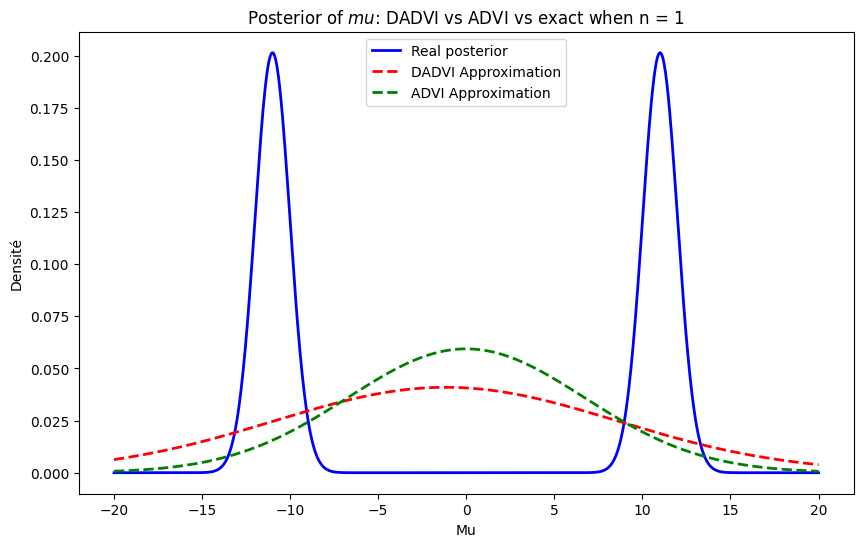

In [24]:
def exact_posterior(mu, p, sigma, sigma0_2, x):
  mean= x*(sigma0_2)/(sigma0_2 + sigma**2)
  var= sigma0_2*sigma**2/(sigma0_2 + sigma**2)

  return(p*norm.pdf(mu, mean, var) + (1-p)*norm.pdf(mu, -mean, var))

mu = np.linspace(-20, 20, 1000)
y_exact = exact_posterior(mu, p, sigma, sigma0_2, data_1)
y_dadvi = norm.pdf(mu, mean_dadvi, np.sqrt(var_dadvi))
y_advi = norm.pdf(mu, mean_advi, np.sqrt(var_advi))

plt.figure(figsize=(10, 6))
plt.plot(mu, y_exact, 'b-', lw=2, label='Real posterior')
plt.plot(mu, y_dadvi, 'r--', lw=2, label='DADVI Approximation')
plt.plot(mu, y_advi, 'g--', lw=2, label='ADVI Approximation')

plt.xlabel('Mu')
plt.ylabel('Densité')
plt.title('Posterior of $mu$: DADVI vs ADVI vs exact when n = 1')
plt.legend()

plt.show()

In [25]:
print(f"ELBO_DADVI = {ELBO_DADVI:.3f}")
print(f"ELBO_ADVI = {ELBO_ADVI:.3f}")


ELBO_DADVI = -18.936
ELBO_ADVI = -23.871


In [26]:
n_samples = 1000
np.random.seed(2)
mu = np.random.normal(0,np.sqrt(sigma0_2))
data = sim(n_samples, mu, sigma, p)


In [27]:
print(mu)

-4.167578474054706


In [28]:
def log_joint_2(mu, log_std, data, p, sigma0_2):
    sigma = np.exp(log_std)  # convert log_sigma to sigma
    n = len(data)
    log_mu = -0.5 * np.log(2 * np.pi * sigma0_2) - 0.5 * mu**2 / sigma0_2

    a = -0.5 * (data - mu)**2 / sigma**2
    b = -0.5 * (data + mu)**2 / sigma**2
    log_probs = logsumexp([np.log(p) + a, np.log(1 - p) + b], axis=0)

    log_x_mu = -0.5 * n * np.log(2 * np.pi * sigma**2) + np.sum(log_probs)
    return log_x_mu + log_mu

def objective_function_2(params, data, log_std, p, sigma0_2, Z):
    eta_1, log_std = params  # log_eta_2 corresponds to log(eta_2)
    eta_2 = (np.exp(log_std))**2  # Convert back to eta_2
    log_joint_sum = 0
    for z in Z:
        mu = eta_1 + z * np.sqrt(eta_2)
        log_joint_sum += log_joint_2(mu, log_std, data, p, sigma0_2)
    log_joint_mean = log_joint_sum / len(Z)
    return -0.5 * log_std - log_joint_mean

In [29]:
log_std = np.log(np.sqrt(sigma0_2))  # Initialisation of log standard deviation

def mini_batch_vi(data, log_sigma, p, sigma0_2, learning_rate=1e-3, batch_size=50, max_epochs=500, epsilon=1e-5):
    eta_1 = 0 # Inialisation of mean
    log_std = np.log(np.sqrt(sigma0_2))  # Initialisation of log standard deviation
    n = len(data)
    costs = []

    prev_params = np.array([eta_1, log_std])

    for epoch in range(max_epochs):
        indices = np.arange(n)
        np.random.shuffle(indices)
        data_shuffled = data[indices]

        for i in range(0, n, batch_size):
            batch = data_shuffled[i:i+batch_size]
            Z = np.random.normal(0, 1, 1)

            # Define local objective function
            def local_obj(params):
                return objective_function_2(params, batch, log_std, p, sigma0_2, Z)

            # Compute gradient numerically using np.gradient method
            grad = gradient_with_npgradient(local_obj, np.array([eta_1, log_std]), delta=1e-5, grid_size=3)

            eta_1 -= learning_rate * grad[0]
            log_std -= learning_rate * grad[1]
            log_std = max(log_std, -10)  # Stabilize log variance by ensuring it's not too negative

        current_params = np.array([eta_1, log_std])
        base_obj = local_obj((eta_1, log_std))
        costs.append(base_obj)

        # Convergence check
        if np.linalg.norm(current_params - prev_params) < epsilon:
            print(f"\nConverged at epoch {epoch + 1}")
            break

        prev_params = current_params.copy()

    # Convert log_std back to variance
    eta_2 = (np.exp(log_std))**2
    return eta_1, eta_2, costs, epoch + 1, base_obj

mean_advi, var_advi, costs, iter, res = mini_batch_vi(data, log_std, p, sigma0_2)

np.random.seed(22)
Z = np.random.normal(0, 1, iter)

ELBO_ADVI = - objective_function_2([mean_advi, var_advi], data, log_std, p, sigma0_2, Z)

print("Optimized mean:", mean_advi)
print("Optimized variance:", var_advi)

Optimized mean: 0.18823277525967796
Optimized variance: 11.279894415248561


In [30]:


initial_params = (0, np.log(np.sqrt(sigma0_2)))  # Initialisation
result = minimize(objective_function_2, initial_params, args=(data, sigma, p, sigma0_2, Z), method='L-BFGS-B')

mean_dadvi, log_std_dadvi = result.x
var_dadvi = np.exp(2* log_std_dadvi)

ELBO_DADVI = - objective_function_2([mean_dadvi, log_std_dadvi], data_1, sigma, p, sigma0_2, Z)

print("Optimized eta_1 (mean):", mean_dadvi)
print("Optimized eta_2 (variance):", var_dadvi)

Optimized eta_1 (mean): -0.6036559577539985
Optimized eta_2 (variance): 9.457208760289248


In [31]:
print("ELBO DADVI:", ELBO_DADVI)
print("ELBO ADVI:", ELBO_ADVI)

ELBO DADVI: -9.432523076570064
ELBO ADVI: -34902936.26185283


In [32]:
#v_n = 1.0 / (n_samples / sigma + 1.0 / sigma0_2)     
#sd  = np.sqrt(v_n)

#weights, means = [], []

#for s_tuple in itertools.product([-1, +1], repeat=n_samples):
 #   s         = np.array(s_tuple)

  #  #prior weight  p^{k}(1-p)^{n-k}
   # k         = np.sum(s == 1)
    #w_prior   = p**k * (1 - p)**(n_samples - k)
    #T         = np.dot(s, data)
    #w_like    = norm.pdf(T, loc=0.0, scale=np.sqrt(n_samples * sigma + sigma0_2))
    #weights.append(w_prior * w_like)
    #means.append(v_n * T / sigma**2)

#normalise the weights 
#weights = np.array(weights)
#weights /= weights.sum()
#means   = np.array(means)

#grid_lo = means.min() - 4*sd
#grid_hi = means.max() + 4*sd
#grid    = np.linspace(grid_lo, grid_hi, 600)

#mix_pdf = np.zeros_like(grid)
#for m, w in zip(means, weights):
 #   mix_pdf += w * norm.pdf(grid, loc=m, scale=sd)


#x = np.linspace(min(data) - 1, max(data) + 1, 1000)

#y_dadvi = norm.pdf(x, mean_dadvi, np.sqrt(var_dadvi))
#y_advi = norm.pdf(x, mean_advi, np.sqrt(var_advi))

#plt.figure(figsize=(10, 6))
#plt.hist(data, bins=30, density=True, alpha=0.5, color='skyblue', label='Dataset')
#plt.plot(grid, mix_pdf, label='Exact mixture posterior')
#plt.plot(x, y_dadvi, 'r-', lw=2, label='DADVI Approximation')
#plt.plot(x, y_advi, 'g--', lw=2, label='ADVI Approximation ')


#plt.xlabel('Values')
#plt.ylabel('Density')
#plt.title('Posterior of $mu$: DADVI vs ADVI vs exact when n>1')
#plt.legend()

#plt.show()